;Load data from the data set into test, training and validation sets

In [1]:
import pandas as pd
import numpy as np
import torch
from datetime import datetime

test = pd.read_csv("datasets/test.csv")
training = pd.read_csv("datasets/training.csv")
validation = pd.read_csv("datasets/validation.csv")

print("Dataset information: ")
print(f'Training data: {training.shape}')
print(f'Validation data: {validation.shape}')
print(f'Test data: {test.shape}')

Dataset information: 
Training data: (16000, 2)
Validation data: (2000, 2)
Test data: (2000, 2)


Load tokenizer, model and create functions needed to process text

In [2]:
import nltk as nltk
import string
from nltk.corpus import stopwords
import re
from transformers import DistilBertTokenizer, DistilBertModel

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-cased')
# Load BERT model
model = DistilBertModel.from_pretrained('distilbert-base-cased')


def preprocess_text(text):
    # remove links
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    # remove html tags
    text = re.sub(r'<.*?>','',text)
    # remove special characters
    text = text.translate(str.maketrans('', '', string.punctuation))

    encoded_input = tokenizer.encode_plus(
        text,
        add_special_tokens=False,
        max_length=512,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )

    return encoded_input['input_ids'], encoded_input['attention_mask']

def extract_features(inputs, masks):
    print('Extract features' + ' - ' + str(datetime.now()))
    with torch.no_grad():
        outputs = model(inputs, attention_mask=masks)
        pooled_output = outputs[0][:, 0, :]
    print('Finish extract features' + ' - ' + str(datetime.now()))
    return pooled_output.numpy()

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Perform batch text preprocessing

In [3]:
# Preprocess training dataset
batch_size = 500
num_batches = len(training) // batch_size
training_features = []
for i in range(num_batches):
    print('Begin preprocess batch ' + str(i) + ' - ' + str(datetime.now()))
    # Get the current batch
    batch_data = training[i * batch_size : (i + 1) * batch_size]['text']
    batch_labels = training[i * batch_size : (i + 1) * batch_size]['label']

    # Preprocess the input text using DistilBERT for the current batch
    batch_inputs = []
    batch_masks = []
    for text in batch_data:
        input_ids, attention_mask = preprocess_text(text)
        batch_inputs.append(input_ids)
        batch_masks.append(attention_mask)

    batch_inputs = torch.cat(batch_inputs, dim=0)
    batch_masks = torch.cat(batch_masks, dim=0)

    pooled_output = extract_features(batch_inputs, batch_masks)
    training_features.append(pooled_output)
    print('Finish preprocess batch ' + str(i) + ' - ' + str(datetime.now()))
# obtain final features and labels
training_features = np.concatenate(training_features, axis=0)
training_labels = training['label'].values[:training_features.shape[0]]

# save the features and labels
np.save('models/training_features-2.npy', training_features)
np.save('models/training_labels-2.npy', training_labels)

Begin preprocess batch 0 - 2023-06-11 17:02:42.291819
Extract features - 2023-06-11 17:02:42.694857
Finish extract features - 2023-06-11 17:07:26.016704
Finish preprocess batch 0 - 2023-06-11 17:07:26.020704
Begin preprocess batch 1 - 2023-06-11 17:07:26.020704
Extract features - 2023-06-11 17:07:26.342704
Finish extract features - 2023-06-11 17:12:01.155823
Finish preprocess batch 1 - 2023-06-11 17:12:01.156823
Begin preprocess batch 2 - 2023-06-11 17:12:01.156823
Extract features - 2023-06-11 17:12:01.502823
Finish extract features - 2023-06-11 17:16:40.379947
Finish preprocess batch 2 - 2023-06-11 17:16:40.380943
Begin preprocess batch 3 - 2023-06-11 17:16:40.380943
Extract features - 2023-06-11 17:16:40.715906
Finish extract features - 2023-06-11 17:21:20.208030
Finish preprocess batch 3 - 2023-06-11 17:21:20.209030
Begin preprocess batch 4 - 2023-06-11 17:21:20.209030
Extract features - 2023-06-11 17:21:20.568030
Finish extract features - 2023-06-11 17:26:12.177842
Finish preproce

Choose a suitable subset of the training data to find the best parameters for the SVM model

Class distribution of the entire training set:  [4666 5362 1304 2159 1937  572]
Class distribution of the subset:  [ 919 1096  278  412  380  115]


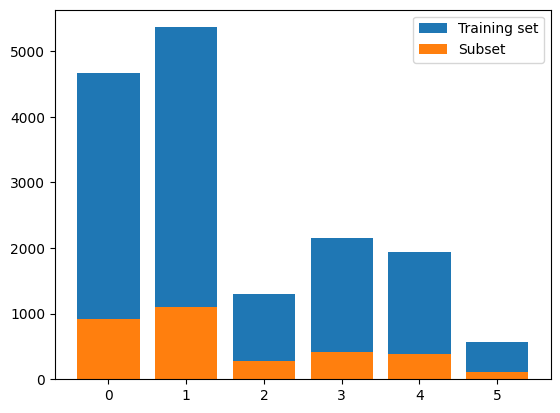

In [4]:
from sklearn.svm import SVC

# load the training features and labels
training_features = np.load('models/training_features-2.npy')
training_labels = np.load('models/training_labels-2.npy')

subset_size = 0.2
# split the training data into a subset and the remaining data
subset_indices = np.random.choice(len(training_features), int(subset_size * len(training_features)), replace=False)
subset_features = training_features[subset_indices]

# compute the class distribution of the subset
subset_labels = training_labels[subset_indices]
subset_class_distribution = np.bincount(subset_labels)

# compute the class distribution of the entire training set
training_class_distribution = np.bincount(training_labels)

# compare the class distributions
print('Class distribution of the entire training set: ', training_class_distribution)
print('Class distribution of the subset: ', subset_class_distribution)

# visualize plots of the class distributions
import matplotlib.pyplot as plt
plt.bar(np.arange(len(training_class_distribution)), training_class_distribution, label='Training set')
plt.bar(np.arange(len(subset_class_distribution)), subset_class_distribution, label='Subset')
plt.legend()
plt.show()


Perform grid search to find the best parameters for the SVM model

In [12]:
# SVM classification
parameters = {
    'C': [ 1, 10, 50, 75],
    'gamma': [1, 0.01, 0.001 , 'scale'],
    'kernel': ['linear', 'rbf', 'poly']
}
# Construct the final SVM
final_svm_classifier = SVC()
# Perform grid search to find the best parameters
from sklearn.model_selection import GridSearchCV
print('Begin grid search' + ' - ' + str(datetime.now()))
grid_search = GridSearchCV(final_svm_classifier, parameters, cv=5)
print('Training final SVM model' + ' - ' + str(datetime.now()))
grid_search.fit(subset_features, subset_labels)
print('Finished training final SVM model' + ' - ' + str(datetime.now()))
print('Best hyperparameters: ', grid_search.best_params_)


Begin grid search - 2023-06-11 20:30:29.905961
Training final SVM model - 2023-06-11 20:30:29.916960
Finished training final SVM model - 2023-06-11 20:48:26.723315
Best hyperparameters:  {'C': 75, 'gamma': 'auto', 'kernel': 'rbf'}


Train the final SVM model with the best parameters

In [13]:
import joblib
# Use the best model for prediction
final_svm_classifier = grid_search.best_estimator_
# use the already existing model
print('Begin training final SVM model' + ' - ' + str(datetime.now()))
final_svm_classifier.fit(training_features, training_labels)
print('Finished training final SVM model' + ' - ' + str(datetime.now()))

Begin training final SVM model - 2023-06-11 20:48:51.151159
Finished training final SVM model - 2023-06-11 20:51:05.581453


Save the generated model for later use

In [14]:
# Save generated SVM model
import joblib
joblib.dump(final_svm_classifier, 'models/model-4.pkl')

['models/model-4.pkl']

Process test data

In [8]:
test_labels = []
test_features = []
# Extract features for test dataset
test_batch_size = 200
num_batches = len(test) // test_batch_size

for i in range(num_batches):
    print('Begin processing for test batch ' + str(i) + ' - ' + str(datetime.now()))
    test_batch_data = test[i * test_batch_size : (i + 1) * test_batch_size]['text']
    test_batch_labels = test[i * test_batch_size : (i + 1) * test_batch_size]['label']
    test_labels.extend(test_batch_labels)
    test_batch_inputs = []
    test_batch_masks = []
    for text in test_batch_data:
        input_ids, attention_mask = preprocess_text(text)
        test_batch_inputs.append(input_ids)
        test_batch_masks.append(attention_mask)
    test_batch_inputs = torch.cat(test_batch_inputs, dim=0)
    test_batch_masks = torch.cat(test_batch_masks, dim=0)
    print(i)
    pooled_output = extract_features(test_batch_inputs, test_batch_masks)
    test_features.append(pooled_output)
    print('End processing for test batch ' + str(i) + ' - ' + str(datetime.now()))

test_labels = torch.tensor(test_labels)
all_test_features = np.concatenate(test_features, axis=0)

Begin processing for test batch 0 - 2023-06-11 19:51:52.708518
0
Extract features - 2023-06-11 19:51:52.863556
Finish extract features - 2023-06-11 19:54:06.856062
End processing for test batch 0 - 2023-06-11 19:54:06.971058
Begin processing for test batch 1 - 2023-06-11 19:54:06.971058
1
Extract features - 2023-06-11 19:54:07.119027
Finish extract features - 2023-06-11 19:56:21.689654
End processing for test batch 1 - 2023-06-11 19:56:21.689654
Begin processing for test batch 2 - 2023-06-11 19:56:21.689654
2
Extract features - 2023-06-11 19:56:21.860682
Finish extract features - 2023-06-11 19:58:35.582044
End processing for test batch 2 - 2023-06-11 19:58:35.583043
Begin processing for test batch 3 - 2023-06-11 19:58:35.583043
3
Extract features - 2023-06-11 19:58:35.764045
Finish extract features - 2023-06-11 20:00:50.164167
End processing for test batch 3 - 2023-06-11 20:00:50.165165
Begin processing for test batch 4 - 2023-06-11 20:00:50.165165
4
Extract features - 2023-06-11 20:00

In [9]:
# save the extracted test features and test labels for later use
np.save('models/test_features-2.npy', all_test_features)
np.save('models/test_labels-2.npy', test_labels)

Predict for the test set

In [15]:
from sklearn.metrics import classification_report
# load the test features and labels
all_test_features = np.load('models/test_features-2.npy')
test_labels = np.load('models/test_labels-2.npy')
print('Begin prediction' + ' - ' + str(datetime.now()))
loaded_svm_classifier = joblib.load('models/model-4.pkl')
predictions = loaded_svm_classifier.predict(all_test_features)
print('Finish prediction' + ' - ' + str(datetime.now()))
report = classification_report(test_labels, predictions)
print(report)

Begin prediction - 2023-06-11 20:51:23.056451
Finish prediction - 2023-06-11 20:51:44.260487
              precision    recall  f1-score   support

           0       0.61      0.72      0.66       581
           1       0.67      0.84      0.75       695
           2       0.46      0.18      0.25       159
           3       0.59      0.37      0.45       275
           4       0.58      0.46      0.51       224
           5       0.58      0.27      0.37        66

    accuracy                           0.63      2000
   macro avg       0.58      0.47      0.50      2000
weighted avg       0.61      0.63      0.60      2000



In [29]:
test_case1 = 'i hope that you realize how such little effort is required to make a person feel better about themselves or their situation whether its me a family member a college or high school friend a neighbor down the street or even a complete stranger'
loaded_svm_classifier = joblib.load('models/model-4.pkl')
input_ids, attention_mask = preprocess_text(test_case1)
test_features = extract_features(input_ids, attention_mask)
prediction = loaded_svm_classifier.predict(test_features)
print("Prediction: ", prediction)

Extract features - 2023-06-11 23:06:36.594557
Finish extract features - 2023-06-11 23:06:38.087558
Prediction:  [1]


In [24]:
validation_labels = []
validation_features = []
# Extract features for test dataset
validation_batch_size = 200
num_batches = len(test) // test_batch_size

for i in range(num_batches):
    print('Begin processing for validation batch ' + str(i) + ' - ' + str(datetime.now()))
    validation_batch_data = test[i * test_batch_size : (i + 1) * test_batch_size]['text']
    validation_batch_labels = test[i * test_batch_size : (i + 1) * test_batch_size]['label']
    validation_labels.extend(validation_batch_labels)
    validation_batch_inputs = []
    validation_batch_masks = []
    for text in validation_batch_data:
        input_ids, attention_mask = preprocess_text(text)
        validation_batch_inputs.append(input_ids)
        validation_batch_masks.append(attention_mask)
    validation_batch_inputs = torch.cat(validation_batch_inputs, dim=0)
    validation_batch_masks = torch.cat(validation_batch_masks, dim=0)
    print(i)
    pooled_output = extract_features(validation_batch_inputs, validation_batch_masks)
    validation_features.append(pooled_output)
    print('End processing for validation batch ' + str(i) + ' - ' + str(datetime.now()))

validation_labels = torch.tensor(validation_labels)
all_validation_features = np.concatenate(validation_features, axis=0)

Begin processing for validation batch 0 - 2023-06-11 21:08:32.536211
0
Extract features - 2023-06-11 21:08:32.673212
Finish extract features - 2023-06-11 21:10:33.760207
End processing for validation batch 0 - 2023-06-11 21:10:33.796209
Begin processing for validation batch 1 - 2023-06-11 21:10:33.796209
1
Extract features - 2023-06-11 21:10:33.937253
Finish extract features - 2023-06-11 21:12:38.172727
End processing for validation batch 1 - 2023-06-11 21:12:38.172727
Begin processing for validation batch 2 - 2023-06-11 21:12:38.172727
2
Extract features - 2023-06-11 21:12:38.339767
Finish extract features - 2023-06-11 21:14:31.856758
End processing for validation batch 2 - 2023-06-11 21:14:31.857759
Begin processing for validation batch 3 - 2023-06-11 21:14:31.857759
3
Extract features - 2023-06-11 21:14:31.995764
Finish extract features - 2023-06-11 21:16:25.898796
End processing for validation batch 3 - 2023-06-11 21:16:25.899792
Begin processing for validation batch 4 - 2023-06-11

In [25]:
# save the extracted validation features and validation labels for later use
np.save('models/validation_features.npy', all_validation_features)
np.save('models/validation_labels.npy', validation_labels)

In [26]:
from sklearn.metrics import classification_report
# load the test features and labels
print('Begin prediction' + ' - ' + str(datetime.now()))
loaded_svm_classifier = joblib.load('models/model-4.pkl')
predictions = loaded_svm_classifier.predict(all_validation_features)
print('Finish prediction' + ' - ' + str(datetime.now()))
report = classification_report(validation_labels, predictions)
print(report)

Begin prediction - 2023-06-11 21:35:25.180981
Finish prediction - 2023-06-11 21:35:46.083985
              precision    recall  f1-score   support

           0       0.61      0.72      0.66       581
           1       0.67      0.84      0.75       695
           2       0.46      0.18      0.25       159
           3       0.59      0.37      0.45       275
           4       0.58      0.46      0.51       224
           5       0.58      0.27      0.37        66

    accuracy                           0.63      2000
   macro avg       0.58      0.47      0.50      2000
weighted avg       0.61      0.63      0.60      2000



In [27]:
# combine the test and validation set
all_test_val_features = np.concatenate((all_test_features, all_validation_features), axis=0)
all_test_val_labels = np.concatenate((test_labels, validation_labels), axis=0)

In [28]:
# use the combined test and validation set to predict with the final model
print('Begin prediction' + ' - ' + str(datetime.now()))
loaded_svm_classifier = joblib.load('models/model-4.pkl')
predictions = loaded_svm_classifier.predict(all_test_val_features)
print('Finish prediction' + ' - ' + str(datetime.now()))
report = classification_report(all_test_val_labels, predictions)
print(report)

Begin prediction - 2023-06-11 21:37:38.247634
Finish prediction - 2023-06-11 21:38:19.897181
              precision    recall  f1-score   support

           0       0.61      0.72      0.66      1162
           1       0.67      0.84      0.75      1390
           2       0.46      0.18      0.25       318
           3       0.59      0.37      0.45       550
           4       0.58      0.46      0.51       448
           5       0.58      0.27      0.37       132

    accuracy                           0.63      4000
   macro avg       0.58      0.47      0.50      4000
weighted avg       0.61      0.63      0.60      4000

